In [17]:
from cassandra.cluster import Cluster
import dash_bootstrap_components as dbc
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# Connect to Cassandra outside of callback function
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace('dmsb_tfm')

In [19]:
query = f"SELECT * FROM CandleSticks_pred"
result = session.execute(query)
result = session.execute(query)
rows = [row._asdict() for row in result]
df_candlesticks_pred = pd.DataFrame(rows)

df_candlesticks_pred.head()

,symbol,start_time,close,high,low,open
0,BTCEUR,2024-04-03 10:29:00,61744.682578,61757.883825,61726.564304,61749.645991
1,BTCEUR,2024-04-03 10:28:00,61751.018948,61773.038483,61744.161087,61763.718328
2,BTCEUR,2024-04-03 10:27:00,61786.295487,61821.479260,61788.079549,61786.328750
3,BTCEUR,2024-04-03 10:26:00,61790.841829,61790.462640,61765.982886,61779.050302
4,BTCEUR,2024-04-03 10:25:00,61788.955514,61791.835277,61769.837912,61772.294386


In [20]:
query = "SELECT * FROM candlesticks"

result = session.execute(query)
rows = [row._asdict() for row in result]
df_candlesticks = pd.DataFrame(rows)

idx = df_candlesticks.groupby('start_time')['event_time'].idxmax()
df_candlesticks = df_candlesticks.loc[idx]
df_candlesticks = df_candlesticks.sort_values(by='start_time', ascending=False)

desired_columns = ['symbol','start_time','close', 'high', 'low', 'open']

df_candlesticks = df_candlesticks.loc[:, desired_columns]


df_candlesticks.head()

,symbol,start_time,close,high,low,open
0,BTCEUR,2024-04-03 10:44:00,61495.83,61520.34,61495.82,61508.04
5,BTCEUR,2024-04-03 10:43:00,61495.24,61522.83,61471.11,61471.11
8,BTCEUR,2024-04-03 10:29:00,61713.63,61729.21,61710.36,61729.20
12,BTCEUR,2024-04-03 10:28:00,61743.53,61756.99,61729.20,61747.97
28,BTCEUR,2024-04-03 10:27:00,61747.96,61778.43,61747.96,61763.82


In [24]:
df_candlesticks_pred.rename(columns={'open': 'open_pred',
                'high': 'high_pred',
                        'low': 'low_pred',
                        'close': 'close_pred'}, inplace=True)
df = pd.merge(df_candlesticks, df_candlesticks_pred, on=['start_time','symbol'], how='inner')

# Extract only the time component from the datetime values
df["start_time"] = df["start_time"].dt.time
df.set_index("start_time", inplace=True)
df.index = df.index.map(lambda x: x.strftime('%H:%M'))
df= df.sort_values(by='start_time', ascending=True)
df.head(10)

,symbol,close,high,low,open,close_pred,high_pred,low_pred,open_pred
start_time,,,,,,,,,
08:56,BTCEUR,61900.09,61925.01,61877.98,61890.69,61869.812251,61883.669912,61860.078596,61858.570697
08:57,BTCEUR,61948.65,61974.26,61910.77,61910.77,61896.829646,61929.029895,61881.509583,61890.043844
08:58,BTCEUR,61933.98,61951.43,61927.85,61951.42,61945.914334,61978.166947,61913.705986,61909.768071
08:59,BTCEUR,61878.39,61934.37,61875.42,61934.37,61934.800014,61947.701677,61929.527484,61951.299016
09:00,BTCEUR,61847.97,61880.02,61818.41,61865.27,61879.733558,61930.392503,61867.553946,61931.905064
09:01,BTCEUR,61908.68,61943.39,61850.80,61850.80,61849.607293,61875.523118,61809.725446,61864.513669
09:02,BTCEUR,61929.98,61930.98,61912.48,61924.86,61905.833131,61949.724601,61855.331988,61853.506977
09:03,BTCEUR,61955.18,61968.12,61936.66,61936.66,61931.816325,61932.396761,61924.345664,61926.405456
09:04,BTCEUR,61960.68,61985.57,61960.68,61964.54,61950.974184,61968.894469,61939.269377,61934.789718


In [6]:
# Calculate summary statistics for actual values
actual_summary = df[['open', 'high', 'low', 'close']].describe()

# Calculate summary statistics for predicted values
predicted_summary = df[['open_pred', 'high_pred', 'low_pred', 'close_pred']].describe()

# Display the summary statistics
print("Summary Statistics for Actual Values:")
print(actual_summary)
print("\nSummary Statistics for Predicted Values:")
print(predicted_summary)


Summary Statistics for Actual Values:
               open          high           low         close
count     83.000000     83.000000     83.000000     83.000000
mean   61833.387108  61849.468313  61813.248554  61831.445783
std       59.690823     62.450252     56.194737     60.188051
min    61729.200000  61729.210000  61710.360000  61713.630000
25%    61786.025000  61800.455000  61767.665000  61790.810000
50%    61824.650000  61837.070000  61800.020000  61818.430000
75%    61876.855000  61896.970000  61858.055000  61876.540000
max    61988.890000  61996.940000  61960.680000  61981.170000

Summary Statistics for Predicted Values:
          open_pred     high_pred      low_pred    close_pred
count     83.000000     83.000000     83.000000     83.000000
mean   61835.174137  61851.174075  61814.788991  61832.836216
std       58.354829     61.666313     56.369845     57.923939
min    61743.830644  61757.883825  61725.988499  61742.012092
25%    61785.494685  61801.210223  61769.656466  617

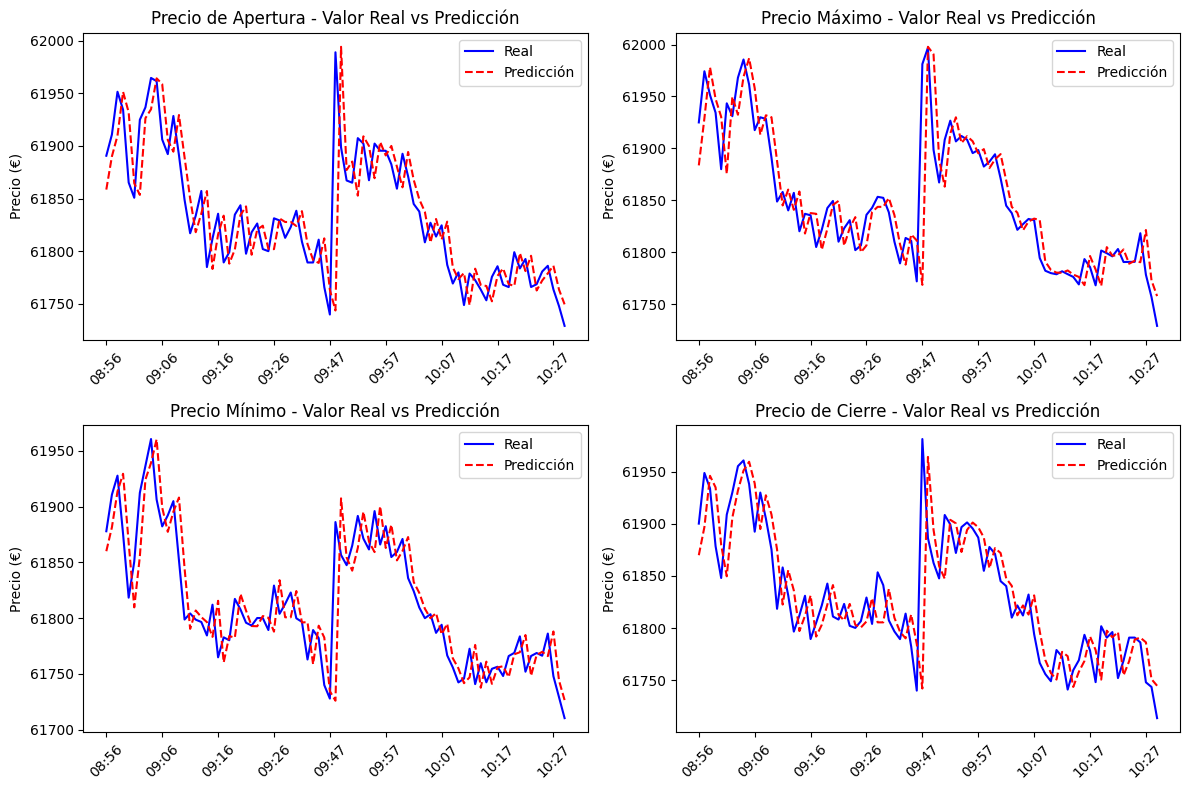

In [26]:
# Plot actual vs predicted values for close, high, low, and open prices
plt.figure(figsize=(12, 8))

# Plot close prices
plt.subplot(2, 2, 4)
plt.plot(df.index, df['close'], label='Real', color='blue')
plt.plot(df.index, df['close_pred'], label='Predicción', linestyle='--', color='red')
plt.xticks(df.index[::10], rotation=45)
plt.ylabel('Precio (€)')
plt.title('Precio de Cierre - Valor Real vs Predicción')
plt.legend()

# Plot high prices
plt.subplot(2, 2, 2)
plt.plot(df.index, df['high'], label='Real', color='blue')
plt.plot(df.index, df['high_pred'], label='Predicción', linestyle='--', color='red')
plt.xticks(df.index[::10], rotation=45)
plt.ylabel('Precio (€)')
plt.title('Precio Máximo - Valor Real vs Predicción')
plt.legend()

# Plot low prices
plt.subplot(2, 2, 3)
plt.plot(df.index, df['low'], label='Real', color='blue')
plt.plot(df.index, df['low_pred'], label='Predicción', linestyle='--', color='red')
plt.xticks(df.index[::10], rotation=45)
plt.ylabel('Precio (€)')
plt.title('Precio Mínimo - Valor Real vs Predicción')
plt.legend()

# Plot open prices
plt.subplot(2, 2, 1)
plt.plot(df.index, df['open'], label='Real', color='blue')
plt.plot(df.index, df['open_pred'], label='Predicción', linestyle='--', color='red')
plt.xticks(df.index[::10], rotation=45)
plt.ylabel('Precio (€)')
plt.title('Precio de Apertura - Valor Real vs Predicción')
plt.legend()

plt.tight_layout()
plt.show()


In [172]:
import plotly.graph_objects as go

# Create candlestick chart for actual data
actual_candlestick = go.Candlestick(x=df.index,
                                    open=df['open'],
                                    high=df['high'],
                                    low=df['low'],
                                    close=df['close'],
                                    name='Actual')

# Create candlestick chart for predicted data
predicted_candlestick = go.Candlestick(x=df.index,
                                       open=df['open_pred'],
                                       high=df['high_pred'],
                                       low=df['low_pred'],
                                       close=df['close_pred'],
                                       name='Predicted',
                                       opacity=0.5)

# Create layout for the plot
layout = go.Layout(title='Actual vs Predicted Candlestick Chart',
                   xaxis=dict(title='Time'),
                   yaxis=dict(title='Price'))

# Combine actual and predicted candlestick charts into a single figure
fig = go.Figure(data=[actual_candlestick, predicted_candlestick], layout=layout)

# Show the plot
fig.show()


In [198]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Función para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Calcular MAE para cada variable
mae_open = mean_absolute_error(actual_candlestick['open'], predicted_candlestick['open'])
mae_high = mean_absolute_error(actual_candlestick['high'], predicted_candlestick['high'])
mae_low = mean_absolute_error(actual_candlestick['low'], predicted_candlestick['low'])
mae_close = mean_absolute_error(actual_candlestick['close'], predicted_candlestick['close'])

# Calcular MSE para cada variable
mse_open = mean_squared_error(actual_candlestick['open'], predicted_candlestick['open'])
mse_high = mean_squared_error(actual_candlestick['high'], predicted_candlestick['high'])
mse_low = mean_squared_error(actual_candlestick['low'], predicted_candlestick['low'])
mse_close = mean_squared_error(actual_candlestick['close'], predicted_candlestick['close'])

# Calcular RMSE para cada variable
rmse_open = np.sqrt(mse_open)
rmse_high = np.sqrt(mse_high)
rmse_low = np.sqrt(mse_low)
rmse_close = np.sqrt(mse_close)

# Calcular MAPE para cada variable
mape_open = mean_absolute_percentage_error(actual_candlestick['open'], predicted_candlestick['open'])
mape_high = mean_absolute_percentage_error(actual_candlestick['high'], predicted_candlestick['high'])
mape_low = mean_absolute_percentage_error(actual_candlestick['low'], predicted_candlestick['low'])
mape_close = mean_absolute_percentage_error(actual_candlestick['close'], predicted_candlestick['close'])

# Imprimir resultados
print("MAE:")
print("Open:", mae_open)
print("High:", mae_high)
print("Low:", mae_low)
print("Close:", mae_close)
print("\nMSE:")
print("Open:", mse_open)
print("High:", mse_high)
print("Low:", mse_low)
print("Close:", mse_close)
print("\nRMSE:")
print("Open:", rmse_open)
print("High:", rmse_high)
print("Low:", rmse_low)
print("Close:", rmse_close)
print("\nMAPE:")
print("Open:", mape_open)
print("High:", mape_high)
print("Low:", mape_low)
print("Close:", mape_close)


MAE:
Open: 26.11534951347565
High: 21.35046467579395
Low: 22.58448570299728
Close: 26.957424106309812

MSE:
Open: 1575.3176947368463
High: 1180.1383927134002
Low: 970.2347005357856
Close: 1534.8711143552339

RMSE:
Open: 39.690272041607955
High: 34.35314239939922
Low: 31.14859066692722
Close: 39.17743118627399

MAPE:
Open: 0.04221768845097677
High: 0.03450500459039582
Low: 0.036527519876451836
Close: 0.04358304624235262


In [201]:
from tabulate import tabulate

# Calcular los valores de MAE, MSE, RMSE y MAPE
mae_values = [mae_open, mae_high, mae_low, mae_close]
mse_values = [mse_open, mse_high, mse_low, mse_close]
rmse_values = [rmse_open, rmse_high, rmse_low, rmse_close]
mape_values = [mape_open, mape_high, mape_low, mape_close]

# Crear una lista de listas con los valores
table_data = [
    ['Variable', 'MAE', 'MSE', 'RMSE', 'MAPE'],
    ['Open', mae_open, mse_open, rmse_open, mape_open],
    ['High', mae_high, mse_high, rmse_high, mape_high],
    ['Low', mae_low, mse_low, rmse_low, mape_low],
    ['Close', mae_close, mse_close, rmse_close, mape_close]
]

# Imprimir la tabla
print(tabulate(table_data, headers='firstrow', tablefmt='pretty'))


+----------+--------------------+--------------------+--------------------+----------------------+
| Variable |        MAE         |        MSE         |        RMSE        |         MAPE         |
+----------+--------------------+--------------------+--------------------+----------------------+
|   Open   | 26.11534951347565  | 1575.3176947368463 | 39.690272041607955 | 0.04221768845097677  |
|   High   | 21.35046467579395  | 1180.1383927134002 | 34.35314239939922  | 0.03450500459039582  |
|   Low    | 22.58448570299728  | 970.2347005357856  | 31.14859066692722  | 0.036527519876451836 |
|  Close   | 26.957424106309812 | 1534.8711143552339 | 39.17743118627399  | 0.04358304624235262  |
+----------+--------------------+--------------------+--------------------+----------------------+
